## Import Necessary Packages

In [1]:
import glob
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats
import metpy.calc as mp
from scipy import interpolate
import proplot as pplt
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

## Import Data

In [2]:
path = '/ocean/projects/atm200007p/sferrett/'
e3sm = np.squeeze(xr.open_dataset(path+'e3sm/E3SM_ANN_000101_000312_climo_PRECL_PRECC_PHIS.nc'))
era5 = xr.merge((xr.open_dataset(path+'era5/ERA5_3D_195906_202108_monthly.nc'),
                 xr.open_dataset(path+'era5/ERA5_2D_195906_202108_monthly.nc')),compat='override')
era5 = era5.reindex(latitude=era5.latitude[::-1]).reindex(level=era5.level[::-1])

In [3]:
lat1=10; lat2=20; lon1=50; lon2=90
era5 = era5.sel(latitude=slice(lat1,lat2),longitude=slice(lon1,lon2)).sel(level=slice(1000,50))

## Calculate Idealized and Complex $B_L$

$ B_L = g\left[w_B\left(\frac{\theta_{eB}-\theta^{*}_{eL}}{\theta^{*}_{eL}}\right) - w_L\left(\frac{\theta^{*}_{eL}-\theta_{eL}}{\theta^{*}_{eL}}\right)\right] $, where $w_B =\frac{a\Delta p_B}{b\Delta p_L} ln \left(\frac{a\Delta p_B+b\Delta p_L}{a\Delta p_B}\right)$ and $w_L = 1 - w_B$

In [4]:
a=1; b=a; rho=1.204; g=9.80665
Td  = mp.dewpoint_from_specific_humidity(era5.level,era5.t,era5.q)
Te  = mp.equivalent_potential_temperature(era5.level,era5.t,Td)
Tes = mp.saturation_equivalent_potential_temperature(era5.level,era5.t)

In [5]:
wB_con = 0.52
wL_con = 0.48
TeB_con  = Te[:7].mean(dim=('level'))
TeL_con  = Te[6:16].mean(dim=('level'))
TesL_con = Tes[6:16].mean(dim=('level'))
BL_con   = (g*(wB_con*((TeB_con-TesL_con)/TesL_con)-wL_con*((TesL_con-TeL_con)/TesL_con)))

In [6]:
bottom = era5.level[0]        
del_pB = era5.level.sel(level=((rho*g*(era5.blh))/100),method='nearest')
split  = era5.level.sel(level=(bottom-del_pB),method='nearest')
top    = era5.level.where(era5.t>273.16).min(dim='level')
del_pL = split-top
wB_var = ((a*del_pB)/(b*del_pL))*np.log((a*del_pB+b*del_pL)/(a*del_pB))
wL_var = 1-wB_var
TeB_var  = Te.where(Te.level>=split).dropna(dim='level').mean(dim='level')
TeL_var  = Te.where((Te.level<=split)&(Te.level>=top)).dropna(dim='level').mean('level')
TesL_var = Tes.where((Tes.level<=split)&(Tes.level>=top)).dropna(dim='level').mean('level')
BL_var   = (g*(wB_var*((TeB_var-TesL_var)/TesL_var)-wL_var*((TesL_var-TeL_var)/TesL_var)))

## Standardize Data and Define Variables

In [7]:
months=['JUN','JUL','AUG']; years=63
z   = e3sm.PHIS.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2)).mean(dim='lat')/g/1000
lon = e3sm.lon.sel(lon=slice(lon1,lon2))
def varprofile(vardata):
    lonslice = era5.longitude.sel(longitude=slice(lon1,lon2)).to_numpy()
    varslice = vardata.sel(longitude=slice(lon1,lon2),latitude=slice(lat1,lat2)).mean(dim='latitude').to_numpy()
    transform = interpolate.interp1d(lonslice,varslice,bounds_error=False)
    data = xr.DataArray(transform(e3sm.lon.sel(lon=slice(lon1,lon2)))).rename({'dim_0':'year','dim_1':'lon'})
    databymonth = xr.concat((data[0::3],data[1::3],data[2::3]),dim='month')
    return databymonth
blcon = varprofile(BL_con)
blvar = varprofile(BL_var)
pr    = varprofile(era5.mtpr*86400)
prlog = xr.ufuncs.log10(pr)
V850  = varprofile(np.sqrt(era5.u[:,6]**2+era5.v[:,6]**2))

## Plot Idealized and Complex $B_L$

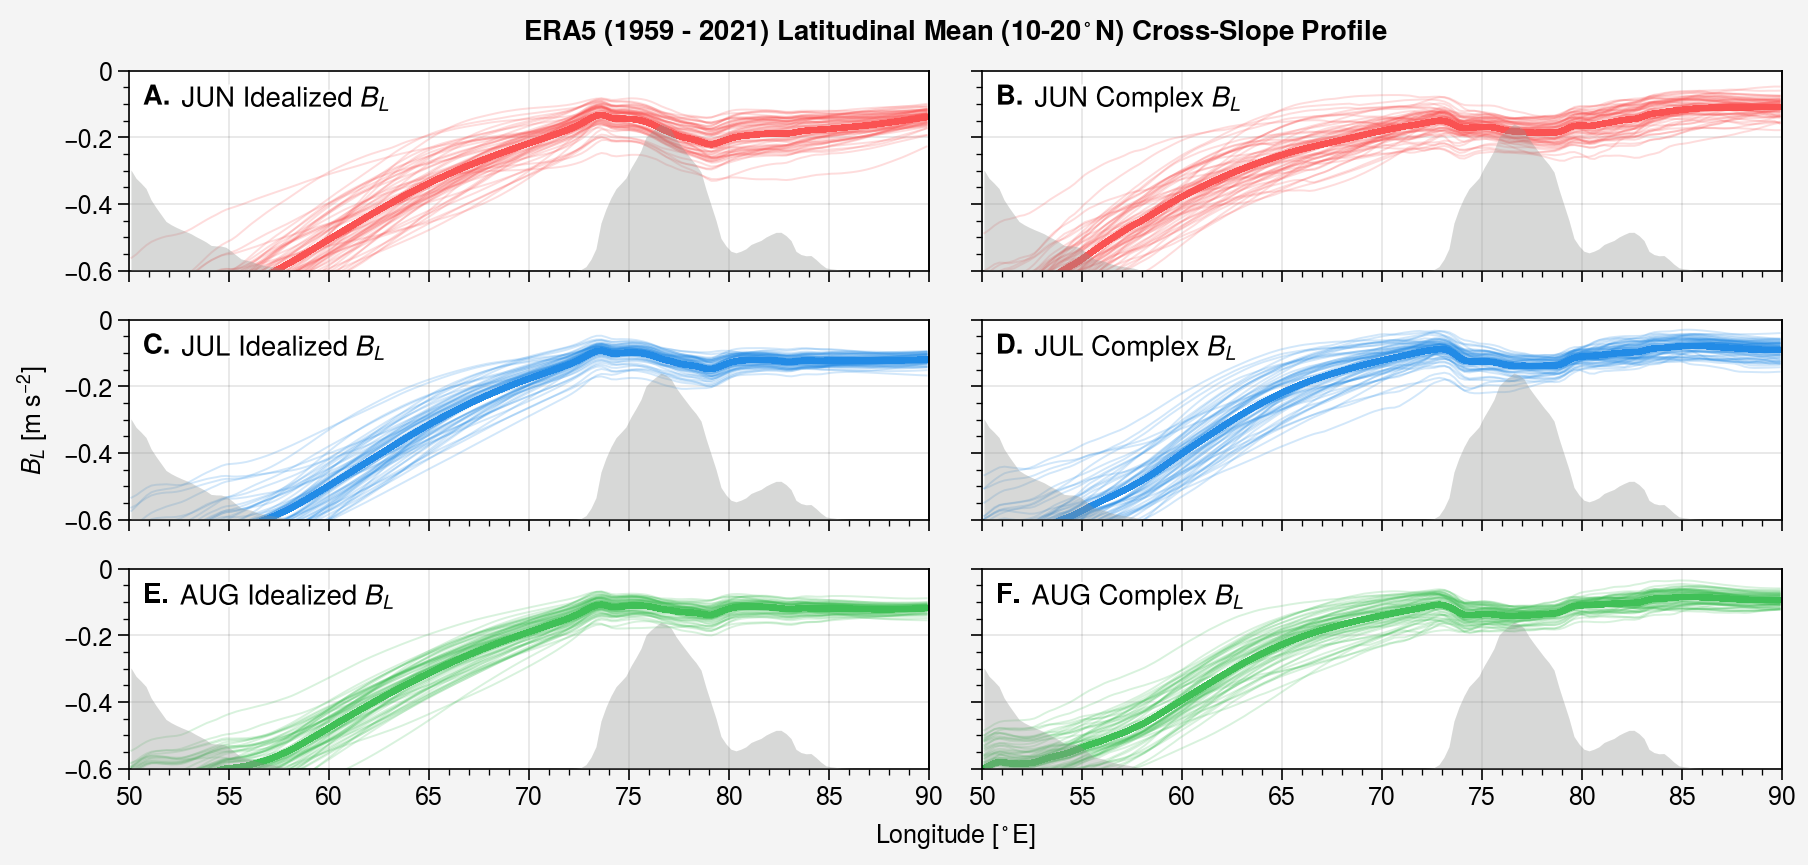

In [8]:
pplt.rc.reso='hi'; colors=np.asarray(['red6','blue6','green6']); alpha=0.2; linewidth=np.asarray([0.7,2])
fig,axs = pplt.subplots(ncols=2,nrows=3,refwidth=4,refheight=1)
axs.format(suptitle='ERA5 (1959 - 2021) Latitudinal Mean ('+str(lat1)+'-'+str(lat2)+'$^\circ$N) Cross-Slope Profile',
           abc='A.',abcloc='ul',xlabel='Longitude [$^\circ$E]',xlim=(50,90),
           ylabel='$\mathit{B_L}$ [m s$^{-2}$]',ylim=(-0.6,0),yticks=0.2)
oxs = axs.twinx()
oxs.fill_between(lon,z,fc='grey',alpha=0.2,zorder=0)
oxs.format(ylim=(0,0.8),ylabel='',yticks='null')
for i,month in enumerate(months): 
    for j in range(years):
        axs[2*i].plot(lon,blcon[i,j],colors=colors[i],alpha=alpha,linewidth=linewidth[0])
        axs[2*i].plot(lon,blcon[i].mean(dim='year'),colors=colors[i],linewidth=linewidth[1])    
        axs[2*i].format(titleloc='ul',title=months[i]+' Idealized $\mathit{B_L}$')      
        axs[2*i+1].plot(lon,blvar[i,j],colors=colors[i],alpha=alpha,linewidth=linewidth[0])
        axs[2*i+1].plot(lon,blvar[i].mean(dim='year'),colors=colors[i],linewidth=linewidth[1])       
        axs[2*i+1].format(titleloc='ul',title=months[i]+' Complex $\mathit{B_L}$')

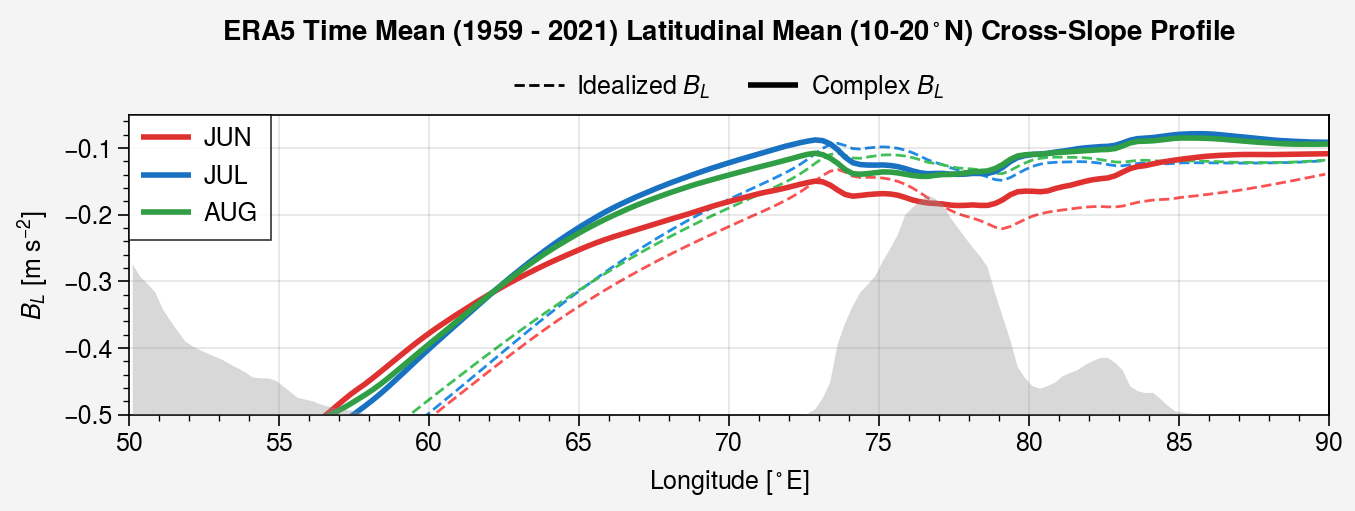

In [9]:
pplt.rc.reso='hi'; darks=np.asarray(['red8','blue8','green8']); lights=np.asarray(['red6','blue6','green6']); key=[]
fig,axs = pplt.subplots(ncols=1,nrows=1,refwidth=6,refheight=1.5)
axs.format(suptitle='ERA5 Time Mean (1959 - 2021) Latitudinal Mean ('
           +str(lat1)+'-'+str(lat2)+'$^\circ$N) Cross-Slope Profile',
           xlabel='Longitude [$^\circ$E]',xlim=(50,90),
           ylabel='$\mathit{B_L}$ [m s$^{-2}$]',ylim=(-0.5,-0.05),yticks=0.1)
oxs = axs.twinx()
oxs.fill_between(lon,z,fc='grey',alpha=0.2,zorder=0)
oxs.format(ylim=(0,0.8),ylabel='',yticks='null')
for i,month in enumerate(months): 
    idea = axs[0].plot(lon,blcon[i].mean(dim='year'),colors=lights[i],linewidth=1,
                       linestyle='--',zorder=1,label='Idealized $\mathit{B_L}$')
    comp = axs[0].plot(lon,blvar[i].mean(dim='year'),colors=darks[i],linewidth=2,
                       linestyle='-',label='Complex $\mathit{B_L}$')
    key.append(comp)
C1=key[0]; C2=key[1]; C3=key[2]    
axs[0].legend([C1,C2,C3],['JUN','JUL','AUG'],loc='ul',ncols=1)
axs[0].legend((idea,comp),color='k',loc='t',ncols=2,frame=False)

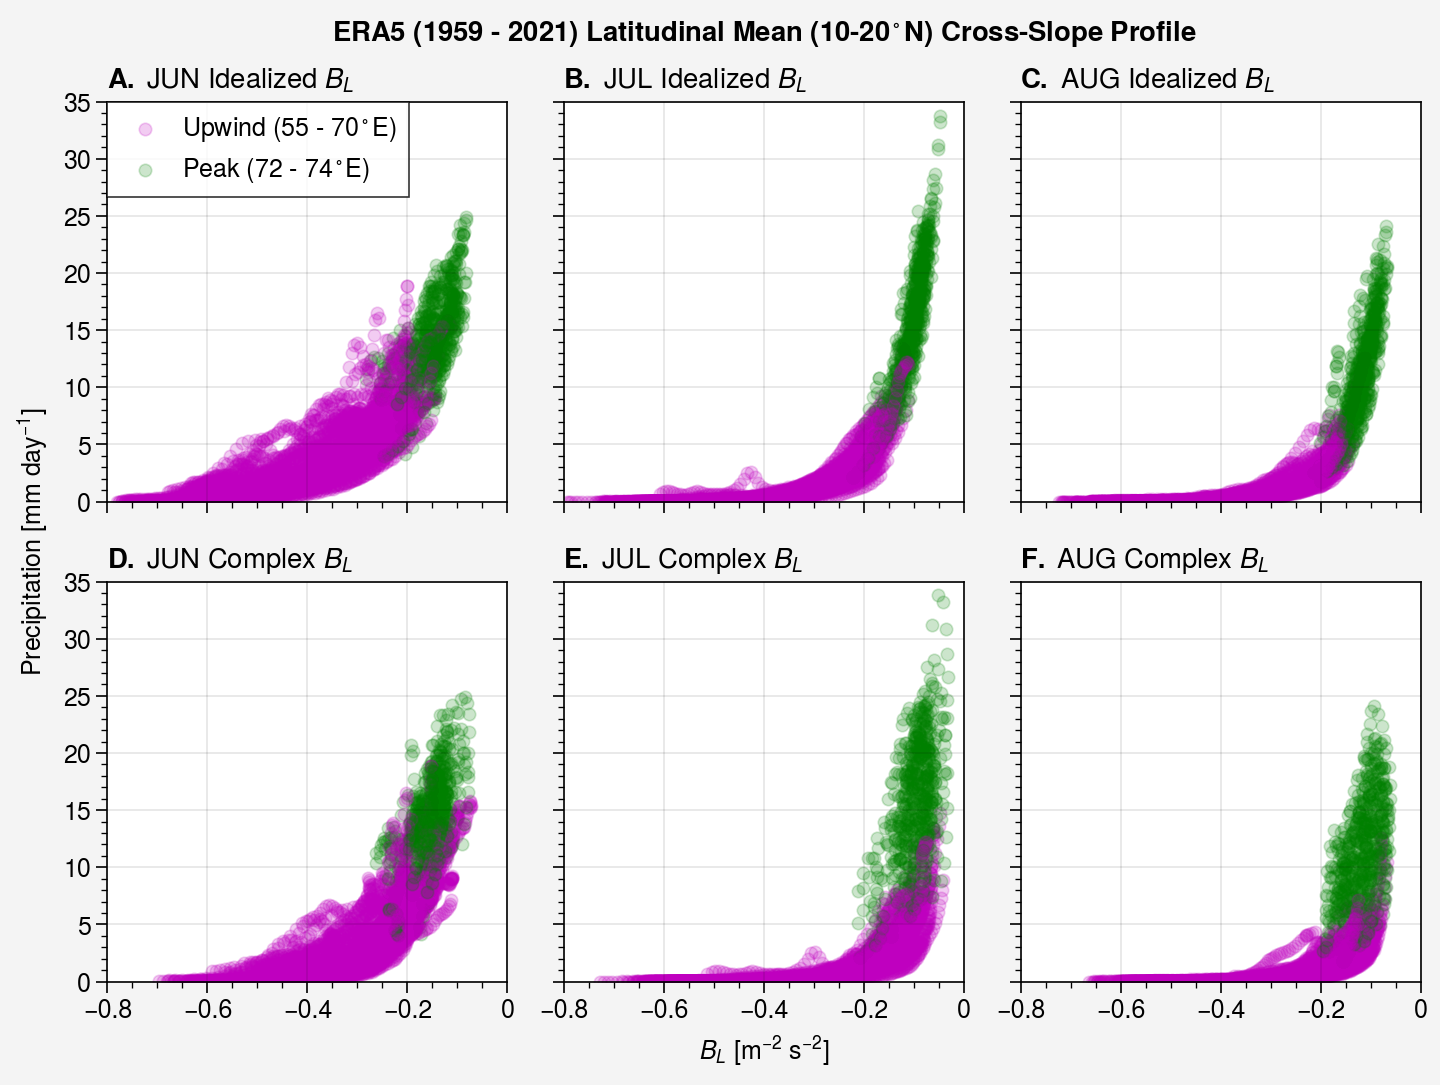

In [10]:
pplt.rc.reso='hi'; s=20; marker='o'; alpha=0.2; key1=[]; key2=[]
fig,axs = pplt.subplots(ncols=3,nrows=2,refheight=2,refwidth=2,sharex=True,sharey=True)
axs.format(suptitle='ERA5 (1959 - 2021) Latitudinal Mean ('+str(lat1)+'-'+str(lat2)+'$^\circ$N) Cross-Slope Profile',
           abc='A.',abcloc='l',titleloc='l',xlabel='$\mathit{B_L}$ [m$^{-2}$ s$^{-2}$]',xlim=(-0.8,0),xticks=0.2,
           ylabel='Precipitation [mm $day^{-1}$]',ylim=(0,35),yticks=5)       
for i,ax in enumerate(months):    
    for j in range(years):                   
        upw = axs[i].scatter(blcon[i,j,20:81],pr[i,j,20:81],colors='m',marker=marker,s=s,alpha=alpha)
        pea = axs[i].scatter(blcon[i,j,88:97],pr[i,j,88:97],colors='g',marker=marker,s=s,alpha=alpha)
        axs[i].format(title=months[i]+' Idealized $\mathit{B_L}$')
        axs[i+3].scatter(blvar[i,j,20:81],pr[i,j,20:81],colors='m',marker=marker,s=s,alpha=alpha)
        axs[i+3].scatter(blvar[i,j,88:97],pr[i,j,88:97],colors='g',marker=marker,s=s,alpha=alpha)
        axs[i+3].format(title=months[i]+' Complex $\mathit{B_L}$')
        key1.append(upw)
        key2.append(pea)
C1=key1[0]; C2=key2[0]
axs[0].legend([C1,C2],['Upwind (55 - 70$^\circ$E)','Peak (72 - 74$^\circ$E)'],loc='ul',ncols=1)

## Plot Wind, Complex $B_L$, and Precipitation

In [11]:
def normalize(vardata):
    return (vardata - np.min(vardata))/(np.max(vardata)-np.min(vardata))
blnorm   = normalize(blvar)
lognorm  = normalize(prlog)
windnorm = normalize(V850)

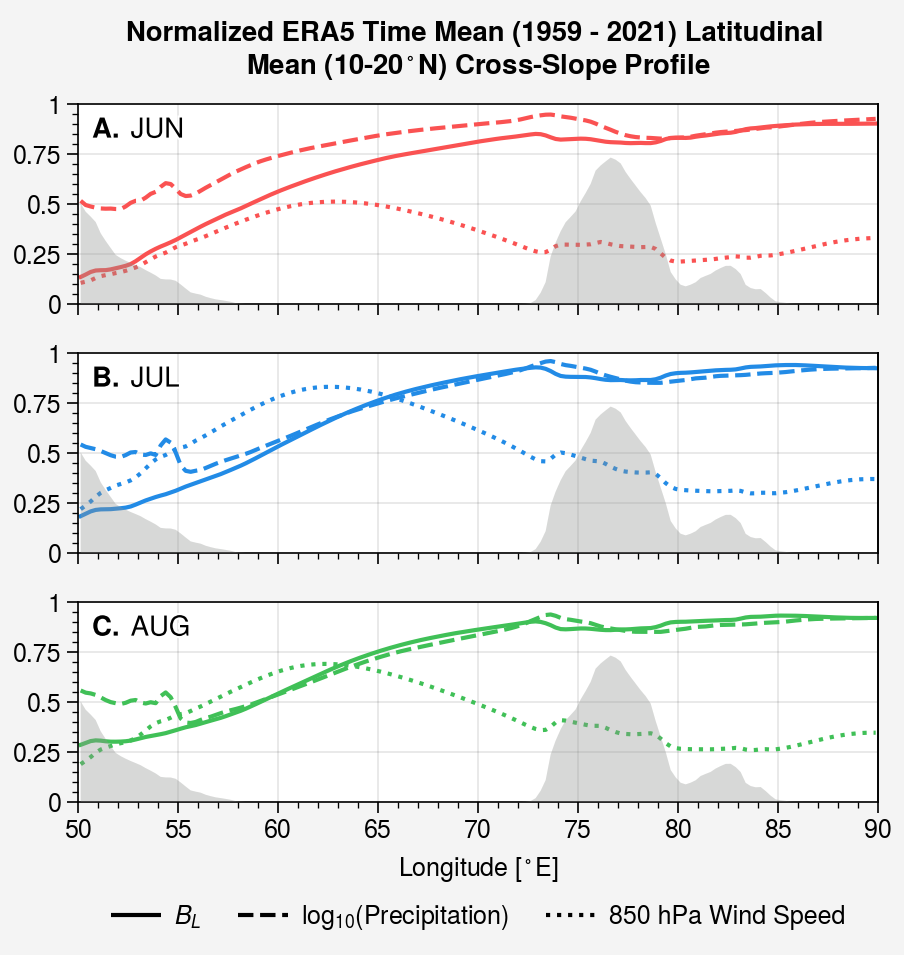

In [12]:
pplt.rc.reso='hi'; colors=np.asarray(['red6','blue6','green6'])
fig,axs = pplt.subplots(ncols=1,nrows=3,refwidth=4,refheight=1,sharey=True)
axs.format(suptitle='Normalized ERA5 Time Mean (1959 - 2021) Latitudinal \nMean ('
           +str(lat1)+'-'+str(lat2)+'$^\circ$N) Cross-Slope Profile',abc='A.',abcloc='ul',
           xlabel='Longitude [$^\circ$E]',xlim=(50,90),ylim=(0,1),yticks=0.25)
oxs = axs.twinx()
oxs.fill_between(lon,z,fc='grey',alpha=0.2,zorder=0)
oxs.format(ylim=(0,0.8),ylabel='',yticks='null')
for i,month in enumerate(months): 
    var = axs[i].plot(lon,blnorm[i].mean(dim='year'),color=colors[i],
                      linestyle='solid',label='$\mathit{B_L}$')
    log = axs[i].plot(lon,lognorm[i].mean(dim='year'),color=colors[i],
                      linestyle='dashed',label='$log_{10}$(Precipitation)')
    win = axs[i].plot(lon,windnorm[i].mean(dim='year'),color=colors[i],
                      linestyle='dotted',label='850 hPa Wind Speed')
    axs[i].format(titleloc='ul',title=months[i])
fig.legend((var,log,win),color='k',loc='b',ncols=3,frame=False)

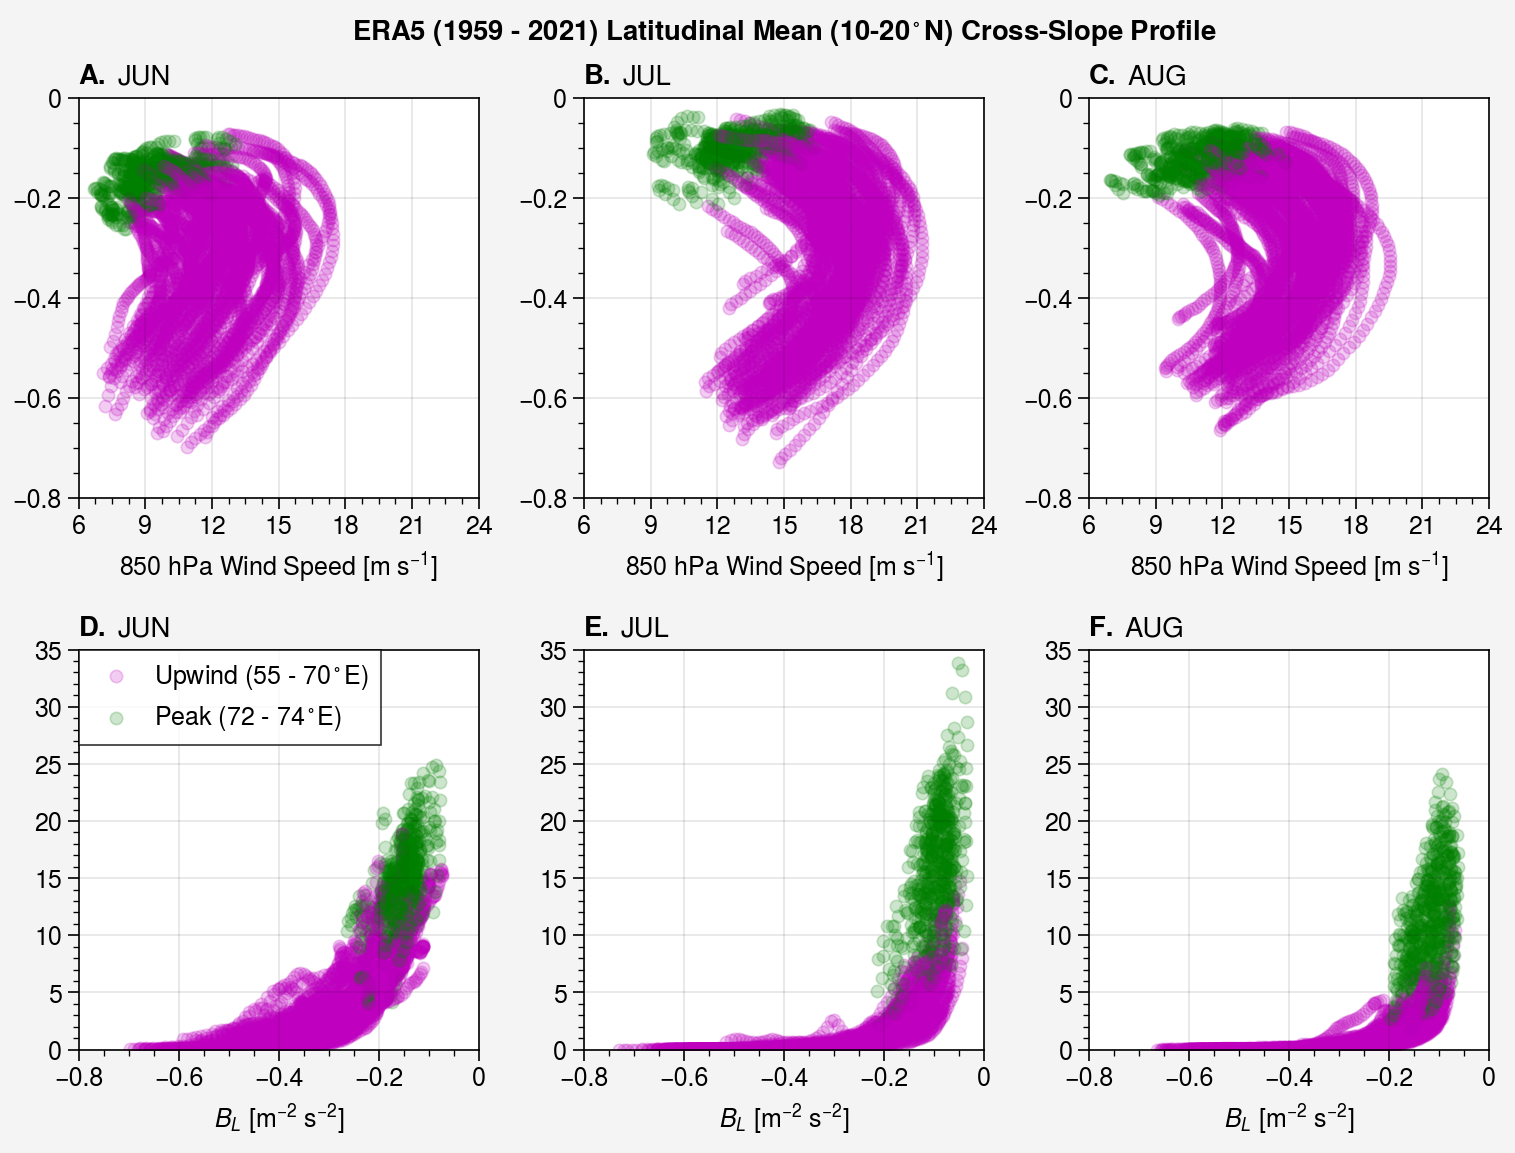

In [13]:
pplt.rc.reso='hi'; s=20; marker='o'; alpha=0.2; key1=[]; key2=[]
fig,axs = pplt.subplots(ncols=3,nrows=2,refheight=2,refwidth=2,sharex=False,sharey=False)
axs.format(suptitle='ERA5 (1959 - 2021) Latitudinal Mean ('+str(lat1)+'-'+str(lat2)+'$^\circ$N) Cross-Slope Profile',
           abc='A.',abcloc='l',titleloc='l')
for i,ax in enumerate(months):    
    for j in range(years):                   
        upw = axs[i].scatter(V850[i,j,20:81],blvar[i,j,20:81],colors='m',marker=marker,s=s,alpha=alpha)
        pea = axs[i].scatter(V850[i,j,88:97],blvar[i,j,88:97],colors='g',marker=marker,s=s,alpha=alpha)
        axs[i].format(xlabel='850 hPa Wind Speed [m s$^{-1}$]',xlim=(6,24),xticks=3,
                      ylim=(-0.8,0),yticks=0.2,title=months[i])
        axs[i+3].scatter(blvar[i,j,20:81],pr[i,j,20:81],colors='m',marker=marker,s=s,alpha=alpha)
        axs[i+3].scatter(blvar[i,j,88:97],pr[i,j,88:97],colors='g',marker=marker,s=s,alpha=alpha)
        axs[i+3].format(xlabel='$\mathit{B_L}$ [m$^{-2}$ s$^{-2}$]',xlim=(-0.8,0),xticks=0.2,
                        ylim=(0,35),yticks=5,title=months[i])
        key1.append(upw); key2.append(pea)
C1=key1[0]; C2=key2[0]
axs[3].legend([C1,C2],['Upwind (55 - 70$^\circ$E)','Peak (72 - 74$^\circ$E)'],loc='ul',ncols=1)

(<matplotlib.legend.Legend at 0x14552d508a90>,
 <matplotlib.legend.Legend at 0x14552d514d90>)

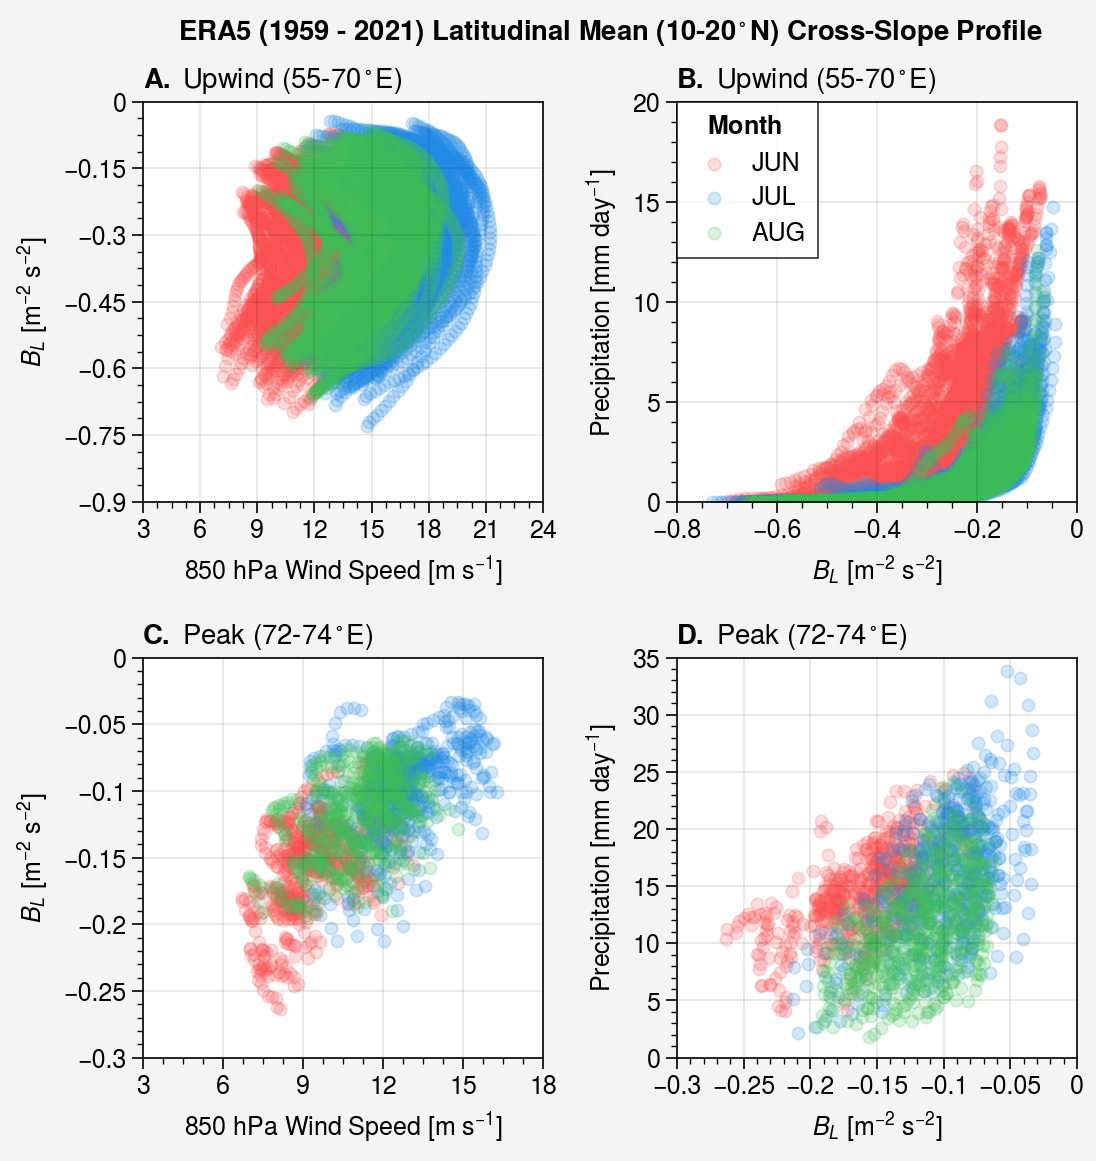

In [14]:
pplt.rc.reso='hi'; colors=np.asarray(['red6','blue6','green6']); s=20; marker='o'; alpha=0.2; key=[]
fig,axs = pplt.subplots(ncols=2,nrows=2,refheight=2,refwidth=2,sharex=False,sharey=False)
axs.format(suptitle='ERA5 (1959 - 2021) Latitudinal Mean ('+str(lat1)+'-'+str(lat2)+'$^\circ$N) Cross-Slope Profile',
           abc='A.',abcloc='l',titleloc='l')
axs[0].format(xlabel='850 hPa Wind Speed [m s$^{-1}$]',xlim=(3,24),xticks=3,
              ylabel='$\mathit{B_L}$ [m$^{-2}$ s$^{-2}$]',ylim=(-0.9,0),yticks=0.15,title='Upwind (55-70$^\circ$E)')
axs[1].format(xlabel='$\mathit{B_L}$ [m$^{-2}$ s$^{-2}$]',xlim=(-0.8,0),xticks=0.2,
              ylabel='Precipitation [mm day$^{-1}$]',ylim=(0,20),yticks=5,title='Upwind (55-70$^\circ$E)')
axs[2].format(xlabel='850 hPa Wind Speed [m s$^{-1}$]',xlim=(3,18),xticks=3,
              ylabel='$\mathit{B_L}$ [m$^{-2}$ s$^{-2}$]',ylim=(-0.3,0),yticks=0.05,title='Peak (72-74$^\circ$E)')
axs[3].format(xlabel='$\mathit{B_L}$ [m$^{-2}$ s$^{-2}$]',xlim=(-0.3,0),xticks=0.05,
              ylabel='Precipitation [mm day$^{-1}$]',ylim=(0,35),yticks=5,title='Peak (72-74$^\circ$E)')
for i,ax in enumerate(months):                       
    dots = axs[0].scatter(V850[i,:,20:81],blvar[i,:,20:81],colors=colors[i],marker=marker,s=s,alpha=alpha)
    axs[1].scatter(blvar[i,:,20:81],pr[i,:,20:81],colors=colors[i],marker=marker,s=s,alpha=alpha)
    axs[2].scatter(V850[i,:,88:97],blvar[i,:,88:97],colors=colors[i],marker=marker,s=s,alpha=alpha)
    axs[3].scatter(blvar[i,:,88:97],pr[i,:,88:97],colors=colors[i],marker=marker,s=s,alpha=alpha)
    key.append(dots)
C1=key[0]; C2=key[1]; C3=key[2]    
axs[1].legend(([C1,C2,C3]),['JUN','JUL','AUG'],loc='ul',ncols=1,title=r'$\bf{Month}$')